<a href="https://colab.research.google.com/github/swimchicken/resnet50_Wafer_detection/blob/main/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 前情提要,首先是為何不能直接套用resnet50
**1.size問題,所以要分開處理**

**2.資料型態問題,resnet50的資料需要特定的樣子,所以要處理成它符合的資料**

# 連結google-drive

In [ ]:
from google.colab import drive
drive.mount("/content/rndrive")

Drive already mounted at /content/rndrive; to attempt to forcibly remount, call drive.mount("/content/rndrive", force_remount=True).


In [ ]:
%cd /content/rndrive/MyDrive/wafer

/content/rndrive/MyDrive/wafer


# 載入函式庫(可能重疊或無用)

In [ ]:
import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import layer_utils, to_categorical, plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import image
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras import regularizers, optimizers
from keras.layers import Dropout

from IPython.display import SVG
import matplotlib.pyplot as plt
from scipy import ndimage, misc

from keras import backend as K
K.clear_session()

%matplotlib inline
from matplotlib import gridspec

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.utils.multiclass import unique_labels
import cv2




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import skimage

from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats


from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from collections import Counter

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier

import itertools
from sklearn.metrics import confusion_matrix

from matplotlib import gridspec

# 引入資料並分析

In [ ]:
df = pd.read_pickle("WM811K.pkl")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
print(df)

        dieSize failureType   lotName trainTestLabel  waferIndex  \
0        1683.0        none      lot1       Training         1.0   
1        1683.0        none      lot1       Training         2.0   
2        1683.0        none      lot1       Training         3.0   
3        1683.0        none      lot1       Training         4.0   
4        1683.0        none      lot1       Training         5.0   
...         ...         ...       ...            ...         ...   
811452    600.0   Edge-Ring  lot47542           Test        23.0   
811453    600.0    Edge-Loc  lot47542           Test        24.0   
811454    600.0   Edge-Ring  lot47542           Test        25.0   
811455    600.0      [0, 0]  lot47543         [0, 0]         1.0   
811456    600.0      [0, 0]  lot47543         [0, 0]         2.0   

                                                 waferMap  
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  

In [ ]:
waferMap_size = df["dieSize"]  #大小
waferMap_type = df["failureType"]  #種類  (共有8種,其中包含none)
waferMap_lotname = df["lotName"]  #WMSR(排序)
waferMap_trainTest = df["trainTestLabel"]  #訓練種類  (包含:train,test,null)
waferMap_index = df["waferIndex"]  #失敗類型(1~25)
waferMap_img = df["waferMap"]  #晶圓圖(0,1,2 組成)


In [ ]:
def replace_arrays(x):
    if isinstance(x, np.ndarray):
        return 9
    else:
        return x
waferMap_trainTest = waferMap_trainTest.apply(replace_arrays)
waferMap_type = waferMap_type.apply(replace_arrays)

In [ ]:
def size(x):
    size_row = np.size(x,axis=0)
    size_col = np.size(x,axis=1)


    return size_row,size_col  #output is turple

df["wafermap_size"] = df.waferMap.apply(size)   #圖形尺寸

In [ ]:
df['failure_num'] = waferMap_type
df['trainTest_num'] = waferMap_trainTest

mapping_type = {'Center' : 0,'Donut' : 1,'Edge-Loc' : 2,'Edge-Ring' : 3,'Loc' : 4,'Random' : 5,'Scratch' : 6,'Near-full' : 7,'none' : 8}

mapping_train_test = {'Training' : 0,'Test' : 1}

df = df.replace({'failure_num':mapping_type, 'trainTest_num':mapping_train_test})



tol_wafers = df.shape[0]

In [ ]:
print(df['failure_num'])

0         8
1         8
2         8
3         8
4         8
         ..
811452    3
811453    2
811454    3
811455    9
811456    9
Name: failure_num, Length: 811457, dtype: int64


In [ ]:
df_with_label = df[(df['failure_num'] >= 0 ) & (df['failure_num'] <= 8)]  #80萬筆資料中,有17萬張為錯誤晶圓資料,其餘為[0,0]==>正解
df_with_label = df_with_label.reset_index()
df_with_patter = df[(df['failure_num'] >= 0 ) & (df['failure_num'] <= 7)]  #去除none==> 類型
df_with_patter = df_with_patter.reset_index()
df_none_patter = df[(df['failure_num'] == 8)]  #只有none==>分辨不出來

In [ ]:
print(df_with_label.shape[0])
print(df_with_patter.shape[0])
print(df_none_patter.shape[0])

172950
25519
147431


In [ ]:
print(df)

        dieSize failureType   lotName trainTestLabel  waferIndex  \
0        1683.0        none      lot1       Training         1.0   
1        1683.0        none      lot1       Training         2.0   
2        1683.0        none      lot1       Training         3.0   
3        1683.0        none      lot1       Training         4.0   
4        1683.0        none      lot1       Training         5.0   
...         ...         ...       ...            ...         ...   
811452    600.0   Edge-Ring  lot47542           Test        23.0   
811453    600.0    Edge-Loc  lot47542           Test        24.0   
811454    600.0   Edge-Ring  lot47542           Test        25.0   
811455    600.0      [0, 0]  lot47543         [0, 0]         1.0   
811456    600.0      [0, 0]  lot47543         [0, 0]         2.0   

                                                 waferMap wafermap_size  \
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      (45, 48)   
1       [[0, 0, 0, 0, 0, 0, 0, 0,

# 分類尺寸資料 ==> (25,27),(26,26),(27,25)

**主要是將尺寸統一成(27,27)**

In [ ]:
sub_df = df.loc[df["wafermap_size"] == (25, 27)]
sub_wafer = sub_df["waferMap"].values

In [ ]:
print(sub_df)
print(sub_df.shape[0])
print(sub_wafer.shape[0])
print(sub_df["failureType"])

        dieSize failureType   lotName trainTestLabel  waferIndex  \
10206     515.0      [0, 0]   lot1904         [0, 0]         8.0   
10207     515.0      [0, 0]   lot1904         [0, 0]         9.0   
10208     515.0      [0, 0]   lot1904         [0, 0]        11.0   
10209     515.0      [0, 0]   lot1904         [0, 0]        12.0   
10210     515.0      [0, 0]   lot1904         [0, 0]        13.0   
...         ...         ...       ...            ...         ...   
742514    515.0      [0, 0]  lot44744         [0, 0]        19.0   
742515    515.0      [0, 0]  lot44744         [0, 0]        20.0   
742516    515.0      [0, 0]  lot44744         [0, 0]        21.0   
742517    515.0      [0, 0]  lot44744         [0, 0]        22.0   
742518    515.0      [0, 0]  lot44744         [0, 0]        23.0   

                                                 waferMap wafermap_size  \
10206   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...      (25, 27)   
10207   [[0, 0, 0, 0, 0, 0, 0, 0,

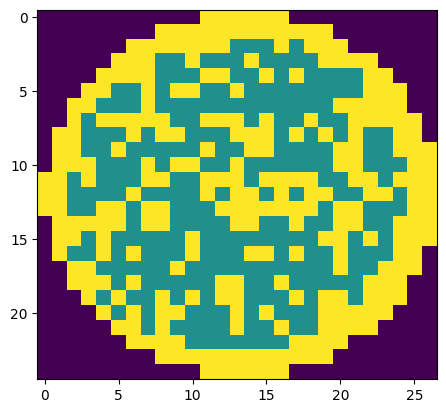

In [ ]:
plt.imshow(sub_df["waferMap"][742518])

In [ ]:
def replace_arrays_1(x):
    if isinstance(x, np.ndarray):
        return []
    else:
        return x

sub_df["failureType"] = sub_df["failureType"].apply(replace_arrays_1)
sub_df["trainTestLabel"] = sub_df["trainTestLabel"].apply(replace_arrays_1)

print(sub_df)


        dieSize failureType   lotName trainTestLabel  waferIndex  \
10206     515.0          []   lot1904             []         8.0   
10207     515.0          []   lot1904             []         9.0   
10208     515.0          []   lot1904             []        11.0   
10209     515.0          []   lot1904             []        12.0   
10210     515.0          []   lot1904             []        13.0   
...         ...         ...       ...            ...         ...   
742514    515.0          []  lot44744             []        19.0   
742515    515.0          []  lot44744             []        20.0   
742516    515.0          []  lot44744             []        21.0   
742517    515.0          []  lot44744             []        22.0   
742518    515.0          []  lot44744             []        23.0   

                                                 waferMap wafermap_size  \
10206   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...      (25, 27)   
10207   [[0, 0, 0, 0, 0, 0, 0, 0,

<ipython-input-23-8c58815a93a0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["failureType"] = sub_df["failureType"].apply(replace_arrays_1)
<ipython-input-23-8c58815a93a0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["trainTestLabel"] = sub_df["trainTestLabel"].apply(replace_arrays_1)


In [ ]:
sw = np.ones((1, 25, 27))
label = list()

for i in range(len(sub_df)):
    if len(sub_df.iloc[i,:]["failureType"]) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]["waferMap"].reshape(1, 25, 27)))
    label.append(sub_df.iloc[i,:]["failureType"])

In [ ]:
print(sw.shape)
print(label)

18782
['Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Edge-Loc', 'Edge-Loc', 'Center', 'Center', 'Center', 'Center', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Edge-Loc', 'Center', 'Center', 'Random', 'Random', 'Random', 'Random', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center', 'Center',

In [ ]:
x1 = sw[1:]
x9 = np.pad(x1, ((0,0),(1,1),(0,0)), mode="constant", constant_values = (0,0))
y9 = np.array(label).reshape((-1,1))
print("x shape : {}, y shape : {}".format(x9.shape, y9.shape))

x shape : (18781, 27, 27), y shape : (18781, 1)


In [ ]:
print(x9)
print(y9)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[['Edge-Lo

In [ ]:
sub_df_2 = df.loc[df['wafermap_size'] == (26, 26)]
sub_wafer_2 = sub_df_2['waferMap'].values
print(sub_df_2)
print(sub_wafer_2)

        dieSize failureType   lotName trainTestLabel  waferIndex  \
150       533.0        none      lot7       Training         1.0   
151       533.0        none      lot7       Training         2.0   
152       533.0        none      lot7       Training         3.0   
153       533.0        none      lot7       Training         4.0   
154       533.0        none      lot7       Training         5.0   
...         ...         ...       ...            ...         ...   
679275    533.0      [0, 0]  lot42180         [0, 0]        20.0   
679276    533.0      [0, 0]  lot42180         [0, 0]        21.0   
679277    533.0      [0, 0]  lot42180         [0, 0]        22.0   
679278    533.0      [0, 0]  lot42180         [0, 0]        23.0   
679279    533.0      [0, 0]  lot42180         [0, 0]        24.0   

                                                 waferMap wafermap_size  \
150     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...      (26, 26)   
151     [[0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def replace_arrays_1(x):
    if isinstance(x, np.ndarray):
        return []
    else:
        return x

sub_df_2["failureType"] = sub_df_2["failureType"].apply(replace_arrays_1)
sub_df_2["trainTestLabel"] = sub_df_2["trainTestLabel"].apply(replace_arrays_1)

print(sub_df_2)

<ipython-input-29-0731c3f25a50>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_2["failureType"] = sub_df_2["failureType"].apply(replace_arrays_1)


        dieSize failureType   lotName trainTestLabel  waferIndex  \
150       533.0        none      lot7       Training         1.0   
151       533.0        none      lot7       Training         2.0   
152       533.0        none      lot7       Training         3.0   
153       533.0        none      lot7       Training         4.0   
154       533.0        none      lot7       Training         5.0   
...         ...         ...       ...            ...         ...   
679275    533.0          []  lot42180             []        20.0   
679276    533.0          []  lot42180             []        21.0   
679277    533.0          []  lot42180             []        22.0   
679278    533.0          []  lot42180             []        23.0   
679279    533.0          []  lot42180             []        24.0   

                                                 waferMap wafermap_size  \
150     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...      (26, 26)   
151     [[0, 0, 0, 0, 0, 0, 0, 0,

<ipython-input-29-0731c3f25a50>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_2["trainTestLabel"] = sub_df_2["trainTestLabel"].apply(replace_arrays_1)


In [ ]:
sw_2 = np.ones((1, 26, 26))
label_2 = list()

In [ ]:
for i in range(len(sub_df_2)):
    if len(sub_df_2.iloc[i,:]['failureType']) == 0:
        continue
    sw_2 = np.concatenate((sw_2, sub_df_2.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label_2.append(sub_df_2.iloc[i,:]['failureType'])

In [ ]:
z = sw_2[1:]
x3 = np.pad(z, ((0,0),(1,0),(1,0)), mode='constant', constant_values = (0,0))
y2 = np.array(label_2).reshape((-1,1))
print('x3 shape : {}, y2 shape : {}'.format(x3.shape, y2.shape))
print(y2)

x3 shape : (14366, 27, 27), y2 shape : (14366, 1)
[['none']
 ['none']
 ['none']
 ...
 ['none']
 ['none']
 ['none']]


In [ ]:
sub_df_3 = df.loc[df['wafermap_size'] == (27, 25)]
sub_wafer_3 = sub_df_3['waferMap'].values


In [ ]:
def replace_arrays_1(x):
    if isinstance(x, np.ndarray):
        return []
    else:
        return x

sub_df_3["failureType"] = sub_df_3["failureType"].apply(replace_arrays_1)
sub_df_3["trainTestLabel"] = sub_df_3["trainTestLabel"].apply(replace_arrays_1)

print(sub_df_3)

        dieSize failureType   lotName trainTestLabel  waferIndex  \
347081    518.0          []  lot20744             []         1.0   
347082    518.0          []  lot20744             []         2.0   
347083    518.0          []  lot20744             []         3.0   
347084    518.0          []  lot20744             []         4.0   
347085    518.0          []  lot20744             []         6.0   
...         ...         ...       ...            ...         ...   
756290    518.0          []  lot45297             []        20.0   
756291    518.0          []  lot45297             []        21.0   
756292    518.0          []  lot45297             []        22.0   
756293    518.0          []  lot45297             []        23.0   
756294    518.0          []  lot45297             []        24.0   

                                                 waferMap wafermap_size  \
347081  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2,...      (27, 25)   
347082  [[0, 0, 0, 0, 0, 0, 0, 0,

<ipython-input-34-cd0c863b2033>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_3["failureType"] = sub_df_3["failureType"].apply(replace_arrays_1)
<ipython-input-34-cd0c863b2033>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_3["trainTestLabel"] = sub_df_3["trainTestLabel"].apply(replace_arrays_1)


In [ ]:
sw_3 = np.ones((1, 27, 25))
label_3= list()

In [ ]:
for i in range(len(sub_df_3)):
    if len(sub_df_3.iloc[i,:]['failureType']) == 0:
        continue
    sw_3 = np.concatenate((sw_3, sub_df_3.iloc[i,:]['waferMap'].reshape(1, 27, 25)))
    label_3.append(sub_df_3.iloc[i,:]['failureType'])

In [ ]:
z1 = sw_3[1:]
x5 = np.pad(z1, ((0,0),(0,0),(1,1)), mode='constant', constant_values = (0,0))
y3 = np.array(label_3).reshape((-1,1))

In [ ]:
print(x5)
print(y3)
print(x5.shape[0])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[['Edge-Lo

# 最後再將合併成一個x-array and y-array

In [ ]:
x3 = np.concatenate((x3, x5[0:]))
y2 = np.concatenate((y2, y3))
x = np.concatenate((x9, x3[0:]))
y = np.concatenate((y9, y2))

print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (43829, 27, 27), y shape : (43829, 1)


In [ ]:
print('Faulty case : {} '.format(y[0]))

Faulty case : ['Edge-Loc'] 


In [ ]:
total = np.unique(y)
for i in total :
    print('{} : {}'.format(i, len(y[y==i])))

Center : 2364
Donut : 7
Edge-Loc : 747
Edge-Ring : 56
Loc : 573
Near-full : 48
Random : 137
Scratch : 102
none : 39795


# 刪除none資料

**註:這邊在結果上準確率約99.6%實在過高,認為是資料懸殊問題(none還是過多)**

**因此可能需要做資料增強的方式使其他類別的資料數提高**

In [ ]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=25000, replace=False)]

new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
print(y)
print(none_idx)

[['Edge-Loc']
 ['Edge-Loc']
 ['Edge-Loc']
 ...
 ['none']
 ['none']
 ['none']]
[25289 25507 37519 ... 33216  2815 16982]


In [ ]:
print("y-long: ",new_y.shape[0])
print("\n")
for i in total:
  print('{} : {}'.format(i, len(new_y[new_y==i])))


y-long:  18829
Center : 2364
Donut : 7
Edge-Loc : 747
Edge-Ring : 56
Loc : 573
Near-full : 48
Random : 137
Scratch : 102
none : 14795


# 切分資料

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=24)

In [ ]:
print("x-train: ",x_train.shape[0])
print("y-train: ",y_train.shape[0])
print("x-test: ",x_test.shape[0])
print("y-test: ",y_test.shape[0])


x-train:  15063
y-train:  15063
x-test:  3766
y-test:  3766


In [ ]:
for i in total:
  print('{} : {}'.format(i, len(y_train[y_train==i])))

Center : 1904
Donut : 7
Edge-Loc : 588
Edge-Ring : 41
Loc : 468
Near-full : 37
Random : 114
Scratch : 82
none : 11822


In [ ]:
for i in total:
  print('{} : {}'.format(i, len(y_test[y_test==i])))

Center : 460
Donut : 0
Edge-Loc : 159
Edge-Ring : 15
Loc : 105
Near-full : 11
Random : 23
Scratch : 20
none : 2973


In [ ]:
print(x_test)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
x_test = x_test.reshape((-1, 27, 27, 1))
print(x_test[0])

[[[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [2.]
  [1.]
  [1.]
  [1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [2.]
  [1.]
  [2.]
  [1.]
  [1.]
  [1.]
  [1.]
  [2.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [1.]
  [1.]
  [0.]
  [2.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [2.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [2.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [0.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [1.]
  [

# one-hot編碼(x and y)

In [ ]:
one_hot_x_test = np.zeros((len(x_test), 27, 27, 3))

for i in range(len(x_test)):
  for j in range(27):
    for k in range(27):
      one_hot_x_test[i,j,k,int(x_test[i,j,k])] = 1

print(one_hot_x_test[0][0])
print(one_hot_x_test.shape)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(3766, 27, 27, 3)


In [ ]:
print(one_hot_x_test.shape)

(3766, 27, 27, 3)


In [ ]:
for i,j in enumerate(total):
  y_test[y_test==j] = i
print(y_test)

[['8']
 ['8']
 ['8']
 ...
 ['8']
 ['2']
 ['8']]


In [ ]:
y_test = to_categorical(y_test)

In [ ]:
print(y_test)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
one_hot_x_train = np.zeros((len(x_train), 27, 27, 3))

for i in range(len(x_train)):
  for j in range(27):
    for k in range(27):
      one_hot_x_train[i,j,k,int(x_train[i,j,k])] = 1

print(one_hot_x_train[0][0])
print(one_hot_x_train.shape)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(15063, 27, 27, 3)


# 建立模型:
# 參考
1.https://towardsdatascience.com/residual-networks-resnets-cb474c7c834a
2.https://jmyao17.github.io/Machine_Learning/Neural_Network/ResNet/ResNet.html

In [ ]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
import tensorflow as tf


In [ ]:
def identity_block(X,f,filters,stage,block):
  conv_name_base = "res" + str(stage) + block + "_branch"
  bn_name_base = "bn" + str(stage) + block + "_branch"

  F1,F2,F3 = filters

  X_shortcut = X


  X = Conv2D(filters = F1,kernel_size = (1,1),strides = (1,1),padding = "valid",name = conv_name_base + "2a",kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + "2a")(X)
  X = Activation("relu")(X)

  X = Conv2D(filters = F2,kernel_size = (f,f),strides = (1,1),padding = "same",name = conv_name_base + "2b",kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + "2b")(X)
  X = Activation("relu")(X)

  X = Conv2D(filters = F3,kernel_size = (1,1),strides = (1,1),padding = "valid",name = conv_name_base + "2c",kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + "2c")(X)

  X = layers.Add()([X,X_shortcut])
  X = Activation("relu")(X)

  return X


In [ ]:

def convolutional_block(X,f,filters,stage,block,s = 2):

  conv_name_base = "res" + str(stage) + block + "_branch"
  bn_name_base = "bn" + str(stage) + block + "_branch"

  F1,F2,F3 = filters

  X_shortcut = X

  X = Conv2D(F1,(1,1),strides=(s,s),name = conv_name_base + "2a",kernel_initializer = glorot_uniform(seed = 0),padding="valid")(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + "2a")(X)
  X = Activation("relu")(X)

  X = Conv2D(F2,(f,f),strides=(1,1),padding = "same",name = conv_name_base + "2b",kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + "2b")(X)
  X = Activation("relu")(X)

  X = Conv2D(F3,(1,1),strides=(1,1),name = conv_name_base + "2c",kernel_initializer = glorot_uniform(seed = 0),padding="valid")(X)
  X = BatchNormalization(axis = 3,name = bn_name_base + "2c")(X)

  X_shortcut = Conv2D(F3,(1,1),strides=(s,s),name = conv_name_base + "1",kernel_initializer = glorot_uniform(seed = 0),padding="valid")(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3,name = bn_name_base + "1")(X_shortcut)

  X = layers.Add()([X,X_shortcut])
  X = Activation("relu")(X)

  return X

# 注意不可使用範例模型層指定大小,由於圖片27*27
# 而不是64*64,因此會有負維度出現



In [ ]:
def ResNet50(input_shape=(27,27,3),classes = 9):
  X_input = Input(input_shape)

  X = ZeroPadding2D((1,1))(X_input)

  X = Conv2D(64,(3,3),name = "conv1",kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3,name = "bn_conv1")(X)
  X = Activation("relu")(X)
  X = MaxPooling2D((2,2))(X)

  X = convolutional_block(X,f = 3,filters = [32,32,128],stage = 2,block = "a",s = 1)
  X = identity_block(X,3,[32,32,128], stage = 2, block = "b")
  X = identity_block(X,3,[32,32,128], stage = 2, block = "c")

  X = convolutional_block(X,f = 3,filters = [64,64,256],stage = 3,block = "a",s = 2)
  X = identity_block(X,3,[64,64,256], stage = 3, block = "b")
  X = identity_block(X,3,[64,64,256], stage = 3, block = "c")
  X = identity_block(X,3,[64,64,256], stage = 3, block = "d")

  X = convolutional_block(X,f = 3,filters = [128,128,512],stage = 4,block = "a",s = 2)
  X = identity_block(X,3,[128,128,512], stage = 4, block = "b")
  X = identity_block(X,3,[128,128,512], stage = 4, block = "c")
  X = identity_block(X,3,[128,128,512], stage = 4, block = "d")
  X = identity_block(X,3,[128,128,512], stage = 4, block = "e")
  X = identity_block(X,3,[128,128,512], stage = 4, block = "f")

  X = convolutional_block(X,f = 3,filters = [256,256,1024],stage = 5,block = "a",s = 2)
  X = identity_block(X,3,[256,256,1024], stage = 5, block = "b")
  X = identity_block(X,3,[256,256,1024], stage = 5, block = "c")

  X = AveragePooling2D(pool_size = (2,2),name = "avg_pool")(X)  #平均池化

  X = Flatten()(X)
  X = Dense(classes,activation="softmax",name="fc" + str(classes),kernel_initializer = glorot_uniform(seed = 0))(X)

  model = models.Model(inputs = X_input,outputs = X,name = "ResNet50")

  return model



In [ ]:
resnet50_model = ResNet50(input_shape = (27,27,3),classes = 9)
resnet50_model.compile(optimizer = optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
print(one_hot_x_train)

[[[[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]]


 [[[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  ...

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]]

  [[1. 0. 0.]
   [1. 0. 0.]
   [1. 0. 0.]
   ...
   [1

In [ ]:
one_hot_x_train = np.delete(one_hot_x_train,(0,0,0,0),1)

In [ ]:
one_hot_x_train = np.delete(one_hot_x_train,(0,0,0,0),2)

In [ ]:
one_hot_x_train = np.pad(one_hot_x_train, ((0,0),(1,0),(1,0),(0,0)), mode='constant', constant_values = (0,0))

In [ ]:
print(one_hot_x_train.shape)

(15063, 27, 27, 3)


In [ ]:
for i,j in enumerate(total):
  y_train[y_train==j] = i
print(y_train)
y_train = to_categorical(y_train)

[['8']
 ['0']
 ['8']
 ...
 ['8']
 ['0']
 ['8']]


# 模型呈現
**(由於colab沒買會員,因此這裡採用vscode編譯後的畫面)**

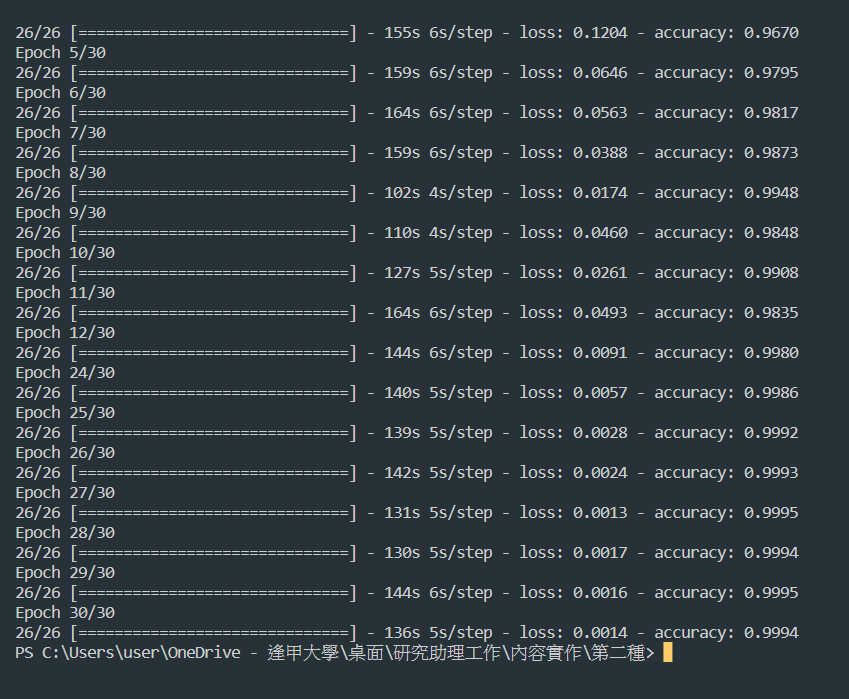




In [ ]:
history = resnet50_model.fit(one_hot_x_train,y_train,epochs=30,validation_batch_size=[one_hot_x_test,y_test],batch_size=600,shuffle=True)

Epoch 1/30
26/26 [==============================] - 540s 20s/step - loss: 0.6695 - accuracy: 0.8679
Epoch 2/30
26/26 [==============================] - 499s 19s/step - loss: 0.2410 - accuracy: 0.9414
Epoch 3/30
26/26 [==============================] - 462s 18s/step - loss: 0.1270 - accuracy: 0.9626
Epoch 4/30
26/26 [==============================] - 462s 18s/step - loss: 0.0808 - accuracy: 0.9742
Epoch 5/30
26/26 [==============================] - 458s 18s/step - loss: 0.0815 - accuracy: 0.9759
Epoch 6/30
26/26 [==============================] - 460s 18s/step - loss: 0.0416 - accuracy: 0.9869
Epoch 7/30
26/26 [==============================] - 451s 17s/step - loss: 0.0250 - accuracy: 0.9911
Epoch 8/30
14/26 [===============>..............] - ETA: 3:35 - loss: 0.0262 - accuracy: 0.9915

# 總結一下整個流程

1.   資料分析
2.   尺寸統一處理

3.   切割資料
4.   圖像增強(未做)
5.   建立模型並訓練
6.   acc:0.96,loss:0.07  (做三次取中位數)

